In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float32)

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
# Expressive LSTM v2
class ProLSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ProLSTM2, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=4, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.PReLU()
    
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros((8, batch_size, self.hidden_size), device=device, requires_grad=True)
        c0 = torch.zeros((8, batch_size, self.hidden_size), device=device, requires_grad=True)
        out, (hn, cn) = self.lstm(x.view(batch_size, 1, -1), (h0, c0))
        out = self.activation(self.linear1(hn[0]))
        out = self.activation(self.linear2(out))
        out = self.linear3(out)
        return out

In [4]:
# Custom Dataset Loader 
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, data):
        
        # Inputs
        self.x = data[:, :-3]
        
        # Output
        self.y = data[:, -3:]
        
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        
        # Inputs
        inp = self.x[idx]
        inp = inp.flatten()
        
        # Outputs
        out = self.y[idx]
        out = out.flatten()
        
        return torch.tensor(inp).float(), torch.tensor(out).float()

# Load the dataset
train_data = np.load("./Dataset/train_28_03.npy")
val_data = np.load("./Dataset/val_28_03.npy")
test_data = np.load("./Dataset/test_28_03.npy")

# Using PyTorch Dataloader
train_dataset = TrajDataset(train_data)
val_dataset = TrajDataset(val_data)
test_dataset = TrajDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=True, num_workers=0)

In [5]:
for batch_num, (datas) in enumerate(train_loader):
    inp, out = datas
    print(inp.shape, out.shape)
    break

torch.Size([64, 44]) torch.Size([64, 3])


In [9]:
# ToyMLP Inputs
input_size = 44
hidden_size = 768
output_size = 3

epochs = 300
model = ProLSTM2(input_size, hidden_size, output_size).to(device)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fn = nn.MSELoss()

avg_train_loss, avg_val_loss = [], []
for epoch in range(epochs):

    # Train Loop
    losses_train = []
    model.train()
    for inp, out in train_loader:

        inp = inp.to(device)
        out = out.to(device)

        # Forward Pass
        pred = model(inp)
        loss = loss_fn(pred, out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach().cpu().numpy())

    # Test Loop
    losses_val = []
    model.eval()
    for inp, out in val_loader:

        inp = inp.to(device)
        out = out.to(device)

        # No Gradients
        with torch.no_grad():
            pred = model(inp)
            val_loss = loss_fn(pred, out)

        losses_val.append(val_loss.detach().cpu().numpy())

    print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f},  Val Loss: {np.average(losses_val):.3f}")

    scheduler.step()
    avg_train_loss.append(np.average(losses_train)), avg_val_loss.append(np.average(losses_val))

Epoch: 1, Train Loss: 4.236,  Val Loss: 3.244
Epoch: 2, Train Loss: 1.938,  Val Loss: 2.708
Epoch: 3, Train Loss: 1.572,  Val Loss: 2.370
Epoch: 4, Train Loss: 1.261,  Val Loss: 1.919
Epoch: 5, Train Loss: 0.941,  Val Loss: 1.629
Epoch: 6, Train Loss: 0.759,  Val Loss: 1.591
Epoch: 7, Train Loss: 0.701,  Val Loss: 1.558
Epoch: 8, Train Loss: 0.673,  Val Loss: 1.575
Epoch: 9, Train Loss: 0.658,  Val Loss: 1.541
Epoch: 10, Train Loss: 0.643,  Val Loss: 1.539
Epoch: 11, Train Loss: 0.636,  Val Loss: 1.521
Epoch: 12, Train Loss: 0.631,  Val Loss: 1.503
Epoch: 13, Train Loss: 0.626,  Val Loss: 1.494
Epoch: 14, Train Loss: 0.624,  Val Loss: 1.482
Epoch: 15, Train Loss: 0.618,  Val Loss: 1.483
Epoch: 16, Train Loss: 0.615,  Val Loss: 1.478
Epoch: 17, Train Loss: 0.613,  Val Loss: 1.467
Epoch: 18, Train Loss: 0.611,  Val Loss: 1.458
Epoch: 19, Train Loss: 0.611,  Val Loss: 1.467
Epoch: 20, Train Loss: 0.607,  Val Loss: 1.459
Epoch: 21, Train Loss: 0.607,  Val Loss: 1.458
Epoch: 22, Train Loss:

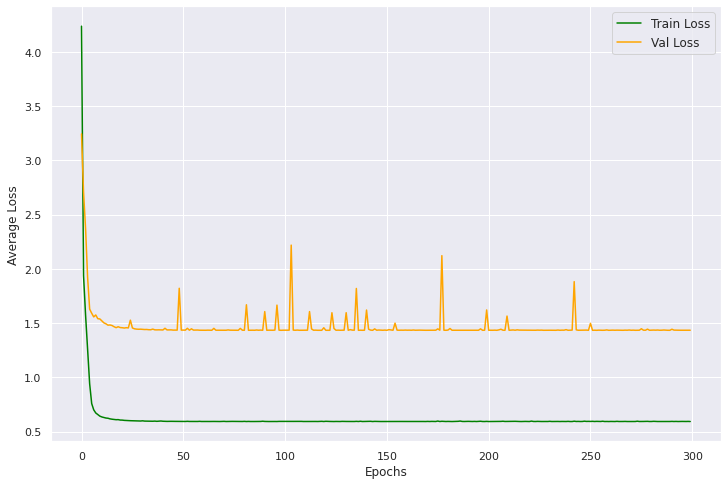

In [10]:
e = np.arange(epoch+1)

plt.figure( figsize=(12, 8))
plt.plot(e, np.array(avg_train_loss), label="Train Loss", color="green")
plt.plot(e, np.array(avg_val_loss), label="Val Loss", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
# plt.ylim([0, 30])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()

In [8]:
# Load the Test Dataset
test_set = torch.from_numpy(train_data)

# Feature and Ground Truth Matrix
X = test_set[:, :-3].to(device)
y = test_set[:, -3:].to(device)

# Inference
with torch.no_grad():
    model.eval()
    test_pred = model(X)

test_loss = loss_fn(test_pred, y)    

print(f"Test MSE Loss: {test_loss:.3f}")

test_set.shape, X.shape, y.shape, test_pred.shape

Test MSE Loss: 0.305


(torch.Size([3834, 47]),
 torch.Size([3834, 44]),
 torch.Size([3834, 3]),
 torch.Size([3834, 3]))

In [25]:
print(test_pred[0:20].cpu().numpy())
print(y[0:20].cpu().numpy())

[[ 1.918747    1.8693073   1.8500634 ]
 [ 3.699289    3.495116    3.1989982 ]
 [ 3.0632598   3.341498    3.1431465 ]
 [ 1.7093068   1.4523512   1.5813563 ]
 [ 2.5922241   2.5406816   2.5177658 ]
 [ 1.6011677   1.6549219   1.727162  ]
 [ 0.10898409 -0.02308429  0.11810133]
 [-0.03430051 -0.01702241  0.02770284]
 [ 1.8793259   1.964349    2.0205152 ]
 [ 2.0230162   2.0916185   2.112853  ]
 [ 1.9989955   1.9585229   1.9370273 ]
 [ 1.8855208   1.7382632   1.7714179 ]
 [ 2.540199    2.45263     2.4275546 ]
 [ 2.880571    2.7681384   2.6992671 ]
 [ 0.01539215 -0.00639003 -0.08018468]
 [ 2.6729522   2.709723    2.6428125 ]
 [ 1.9807323   1.9257026   1.9235156 ]
 [ 2.6194036   2.5486887   2.500704  ]
 [ 2.0586367   2.1225896   2.154225  ]
 [ 1.8237073   1.8409206   1.8799174 ]]
[[ 2.1329324e+00  1.9959427e+00  2.4003978e+00]
 [ 4.6664176e+00  4.4596376e+00  4.5897226e+00]
 [ 5.4812889e+00  3.6353908e+00  2.3516319e+00]
 [ 1.4946039e+00  1.5523056e+00  1.4458112e+00]
 [ 2.5617898e+00  2.4192309

In [ ]:
t = np.linspace(0, X.shape[0], X.shape[0])*0.05

%matplotlib qt
plt.figure( figsize=(18, 12))
plt.plot(t, y.cpu().numpy(), label="Ground Truth", color="blue")
plt.plot(t, test_pred.cpu().numpy(), label="Predictions", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
plt.xlim(0, 5)
# plt.ylim(-10, 10)
plt.xlabel("t")
plt.ylabel("Angular Velocity")
# plt.savefig("GRU Predictions.png")
plt.show()